### GYM Workout Visualization
By Han Sun

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib        as mpl

%matplotlib inline

mpl.rc( 'font', family = 'serif' )
mpl.rc( 'text', usetex = True    )

mpl.rcParams[ 'font.size'        ] = 10
mpl.rcParams[ 'axes.labelsize'   ] = 10
mpl.rcParams[ 'legend.fontsize'  ] = 10
mpl.rcParams[ 'legend.edgecolor' ] = 'k'
mpl.rcParams[ 'figure.facecolor' ] = 'w'
mpl.rcParams[ 'lines.linewidth' ] = 1

from itertools import cycle
cycol =    cycle('bgrcmyk')
cymarker = cycle('ov^')

from matplotlib import font_manager

fontP = font_manager.FontProperties()
fontP.set_family('SimHei')

#### the data loader: workout_data

In [106]:
class workout_data:
    def __init__( self, start, end ):
        self.row_idx = {'Shoulder': list(range(0, 6)), 
                        'Back':     list(range(8, 15)), 
                        'Chest':    list(range(17, 26)), 
                        'Arm':      list(range(28, 37))}
        self.cycles = []*(end-start)
        
        for cycle_i in range(start, end+1):
            cycle = {}
            cycle['idx'] = cycle_i
            sheet = pd.read_excel('GYM.xlsx', sheet_name='Week#' + str(cycle_i) )
            for _, range_ in self.row_idx.items():
                part_block = sheet.iloc[range_, :]
                cycle[ part_block.iloc[0, 0] ] = part_block
            
            self.cycles.append(cycle)
            
    def visualize_general( self, part_names ):
        
        plt.figure(dpi=150)
        ylim_max = 0
        for part_name in part_names:
            X, y = [], []
            for cycle in self.cycles:
                X.append(cycle['idx'])
                part_block = cycle[part_name]
                y.append( sum(part_block.iloc[:, -1]) )
        
            plt.plot(X, y, marker='o', color=next(cycol), label=part_name)
            ylim_max = max(ylim_max, max(y)*1.2)
            plt.ylim([0, ylim_max])
                
        plt.ylabel('Total Volume, lb')
        plt.xlabel('No. of Cycle')
        plt.legend()
        plt.show()
        return
    
    def visualize_part( self, part_name ):
        plt.figure(dpi=150)
        ylim_max = 0
        
        X = []
        num_practice = len(self.row_idx[part_name])
        Y = [[0]*len(self.cycles) for _ in range(num_practice)]
        
        for i_cycle, cycle in enumerate(self.cycles):
            X.append(cycle['idx'])
            part_block = cycle[part_name]
            for i_practice in range(num_practice):
                Y[i_practice][i_cycle] = part_block.iloc[i_practice, -1]
        
        labels = list(part_block.iloc[:, 1])
        for ii, y in enumerate(Y):
            ylim_max = max(ylim_max, max(y)*1.2)
            plt.plot(X, y, label=str(ii), color=next(cycol), marker=next(cymarker))
        plt.ylabel('Total Volume, lb')
        plt.xlabel('No. of Cycle')
        plt.legend(bbox_to_anchor=(1.2, 1), prop=fontP)
        plt.show()
        return
        

### Test out!

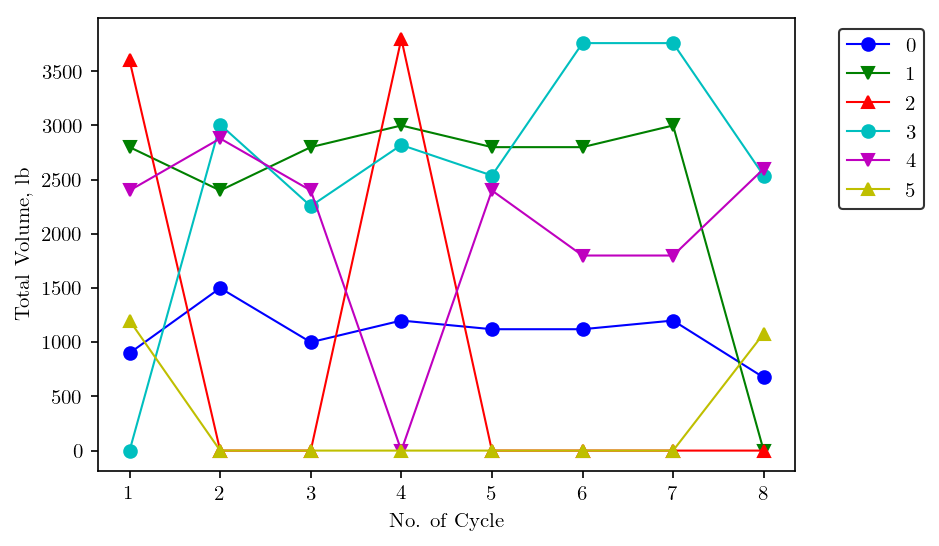

In [107]:
my_workout = workout_data(1, 8)
my_workout.visualize_part( 'Shoulder' )

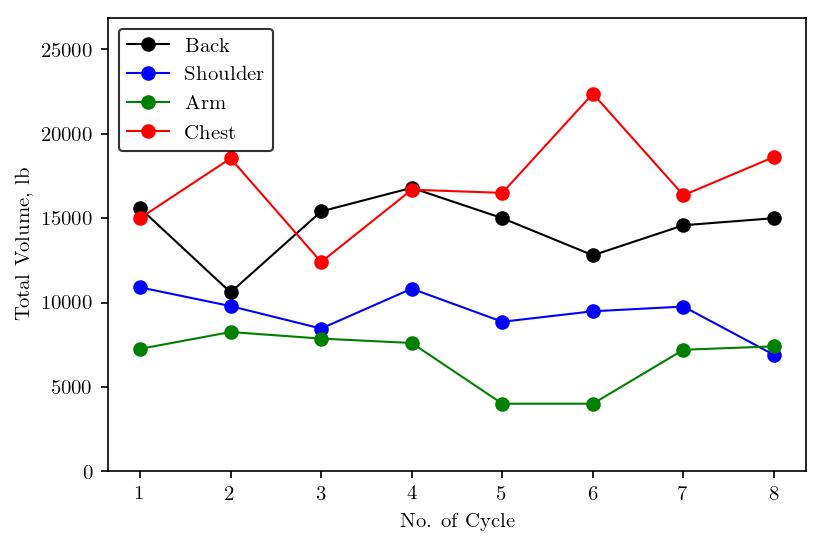

In [108]:
my_workout.visualize_general( ['Back', 'Shoulder', 'Arm', 'Chest'] )

In [102]:
Y = [[0]*10 for _ in range(5)]
Y

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]